In [1]:
import csv
import copy
import ast
import re
import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd

from Bio import SeqIO
from Bio.Seq import Seq

from matplotlib import pyplot as plt

In [2]:
def align_read(querystr,cigarstr,pattern=re.compile("[0-9]{0,10}[MDI]")):
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    return output_str
def cigarsfromsam(samfilepath):
    cigars = {}
    with open(samfilepath,"r") as samfile:
        for line in samfile:
            if line[0]=="@":
                next(samfile)
            else:
                splitline = line.split("\t")
                cigars[splitline[0]] = splitline[5]
    return cigars

def strsfromfasta(fastafilepath):
    queries = SeqIO.to_dict(SeqIO.parse(fastafilepath,"fasta"))
    queries = {key: str(val.seq) for key,val in queries.items()}
    return queries

def make_seg_dict(gfafile):
    segment_dict = {}
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                segment_dict[splitline[1]] = splitline[2][:-1]
    return segment_dict

def get_ref_intervals(gfafile):
    segment_dict = {}
    current_idx = 0
    with open(gfafile,"r") as infile:
        for line in infile:
            if line[0] == "S":
                splitline = line.split("\t")
                if "OFF" not in splitline[1]:
                    refstr = splitline[2][:-1]
                    strlen = len(refstr)
                    name = splitline[1]
                    if "ON" in name:
                        name=name[:-2]
                    segment_dict[name] = tuple((current_idx,current_idx+strlen))
                    current_idx += strlen
    return segment_dict
def align_read(querystr,refstr,cigarstr,startpos=1,pattern=re.compile("[0-9]{0,10}[MDI]")):
    start_pos = startpos-1 ##comes as 1 indexed from minimap
    result = pattern.finditer(cigarstr)
    cigar_seq = [(item.group(0)[-1],int(item.group(0)[:-1])) for item in result]
#     output_str = "".join(["-" for i in range(cigar[1])])
    output_str = ""
    if start_pos > 0:
        output_str += "".join(["-" for i in range(start_pos)])
    current_idx = 0
    for item in cigar_seq:
        if item[0]=="M":
            added_str = querystr[current_idx:current_idx+item[1]]
            output_str += added_str
            current_idx += item[1]
        elif item[0]=="D":
            added_str = "".join(["-" for i in range(item[1])])
            output_str += added_str
        elif item[0]=="I":
            current_idx += item[1]
    remaining_len = len(refstr)-len(output_str)
    if remaining_len>0:
        output_str += "".join(["-" for i in range(remaining_len)])
    return output_str

def splitstr(instr,ref_intervals):    
    strassign = {key:instr[val[0]:val[1]] for key,val in ref_intervals.items()}
    return strassign

def slow_hamming_distance(s1, s2):
    if len(s1) != len(s2):
        print(s1,s2)
        raise ValueError("Strand lengths are not equal!")
    term_list = []
    for ch1,ch2 in zip(s1,s2):
        if ch1 == "N" or ch2 == "N":
            term_list.append(False)
        else:
            term_list.append(ch1 != ch2)
    result = sum(term_list)
    return result

def get_dict_dist(dict1,dict2):
    hamming_dict = {key:slow_hamming_distance(dict1[key],dict2[key]) for key in dict1.keys()}
    return hamming_dict

In [3]:
data = pd.read_csv("/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/output.tsv",delimiter="\t")
ref_intervals = get_ref_intervals("./aDE12.gfa")
barcodes = set(data["barcode"].tolist())

In [4]:
bit_arr = np.array([list(item) for item in barcodes]).astype('uint8')
bit_freq = np.mean(bit_arr,axis=0)

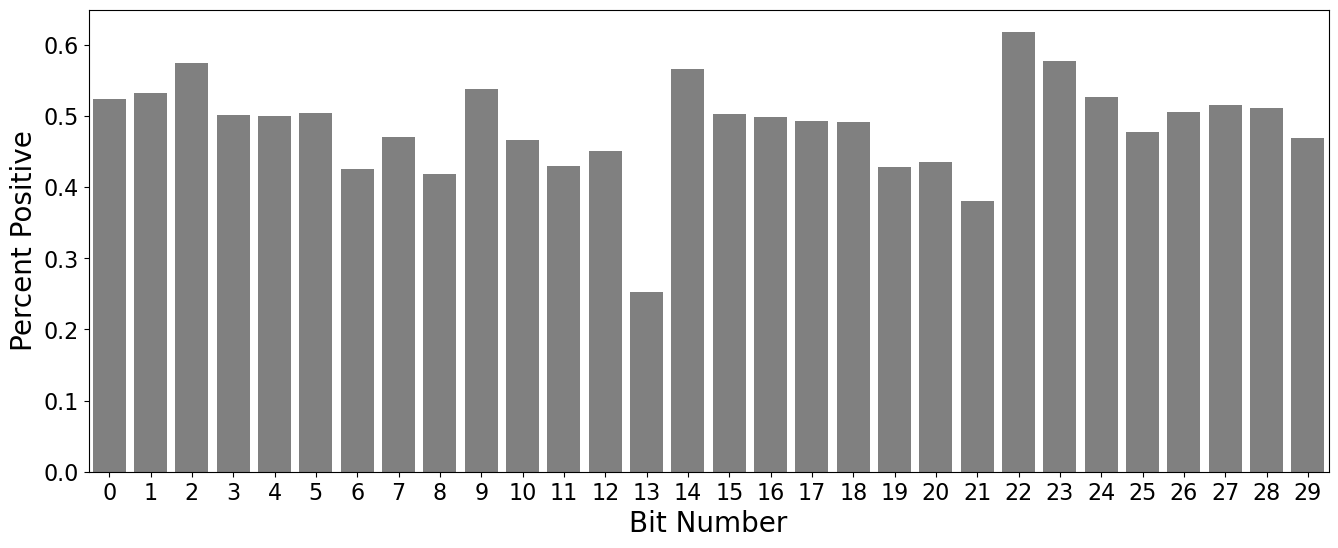

In [5]:
fig = plt.figure(figsize=(16, 6))
sns.barplot(x=list(range(len(bit_freq))), y=bit_freq, color="grey")
plt.xlabel("Bit Number",fontsize=20)
plt.ylabel("Percent Positive",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/figure_1.png",dpi=300,bbox_inches="tight")
plt.show()

In [6]:
len(barcodes)

15020

In [7]:
import os
import shutil
import dask
import time
import h5py

from time import sleep
from dask.distributed import Client,progress
from dask_jobqueue import SLURMCluster
from IPython.core.display import display, HTML
import dask.array as da

def writedir(directory,overwrite=False):
    if overwrite:
        if os.path.exists(directory):
            shutil.rmtree(directory)
        os.makedirs(directory)
    else:
        if not os.path.exists(directory):
            os.makedirs(directory)

class tr_dask_controller: #adapted from Charles' code
    def __init__(self,n_workers=6,local=True,queue="short",death_timeout=3.,\
                 walltime='01:30:00',cores=1,processes=1,memory='6GB',\
                 working_directory="./",job_extra=[]):
        self.local = local
        self.n_workers = n_workers
        self.walltime = walltime
        self.queue = queue
        self.death_timeout = death_timeout
        self.processes = processes
        self.memory = memory
        self.cores = cores
        self.working_directory = working_directory
        self.job_extra = job_extra

        writedir(working_directory,overwrite=False)

    def startdask(self):
        if self.local:
            self.daskclient = Client()
            self.daskclient.cluster.scale(self.n_workers)
        else:
            self.daskcluster = SLURMCluster(n_workers=self.n_workers,queue=self.queue,death_timeout=self.death_timeout,walltime=self.walltime,\
                                   processes=self.processes,memory=self.memory,\
                                  cores=self.cores,local_directory=self.working_directory,\
                                log_directory=self.working_directory,job_extra=self.job_extra)
#             self.workers = self.daskcluster.start_workers(self.n_workers)
            self.daskclient = Client(self.daskcluster)

    def shutdown(self):
        self.daskclient.restart()
        if not self.local:
            self.daskcluster.close()
        for item in os.listdir(self.working_directory):
            if "worker-" in item or "slurm-" in item or ".lock" in item:
                path = "./" + item
                if os.path.isfile(path):
                    os.remove(path)
                elif os.path.isdir(path):
                    shutil.rmtree(path)

    def printprogress(self):
        complete = len([item for item in self.futures if item.status=="finished"])
        print(str(complete) + "/" + str(len(self.futures)))

    def displaydashboard(self):
        link = self.daskcluster.dashboard_link
        display(HTML('<a href="' + link +'">Dashboard</a>'))

    def mapfovs(self,function,fov_list,retries=0):
        self.function = function
        self.retries = retries
        def mapallfovs(fov_number,function=function):
            function(fov_number)
        self.futures = {}
        for fov in fov_list:
            future = self.daskclient.submit(mapallfovs,fov,retries=retries)
            self.futures[fov] = future

    def retry_failed(self):
        self.failed_fovs = [fov for fov,future in self.futures.items() if future.status != 'finished']
        out = self.daskclient.restart()
        self.mapfovs(self.function,self.failed_fovs,retries=self.retries)

    def retry_processing(self):
        self.proc_fovs = [fov for fov,future in self.futures.items() if future.status == 'pending']
        out = self.daskclient.restart()
        self.mapfovs(self.function,self.proc_fovs,retries=self.retries)

/tmp/ipykernel_22571/1146434497.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
dask_controller = tr_dask_controller(
    walltime="02:00:00",
    local=False,
    n_workers=40,
    memory="16GB",
    working_directory= "/home/lag36/scratch/lag36/dask",
)

dask_controller.startdask()

/home/lag36/miniconda3/envs/crispri/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home/lag36/miniconda3/envs/crispri/lib/python3.10/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [9]:
dask_controller.daskclient

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.120.16.78:8787/status,
Dashboard: http://10.120.16.78:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.120.16.78:41194,Workers: 0
Dashboard: http://10.120.16.78:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [18]:
dask_controller.shutdown()

/home/lag36/miniconda3/envs/nanopore/lib/python3.8/site-packages/dask_jobqueue/core.py:251: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
2023-03-28 09:52:21,591 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [10]:
bit_arr.shape

(15020, 30)

In [42]:
# dask_bit_arr = da.from_array(bit_arr,chunks=(10000,30)).astype("uint8")
dask_bit_arr = da.from_array(bit_arr,chunks=(1000,30)).astype("uint8")

In [43]:
dask_bit_arr

dask.array<array, shape=(15020, 30), dtype=uint8, chunksize=(1000, 30), chunktype=numpy.ndarray>

In [44]:
15020/20

751.0

In [45]:
dask_bit_arr.shape[0]

15020

In [46]:
dask_bit_arr.chunksize

(1000, 30)

In [47]:
n_chunks = 5
step = dask_bit_arr.chunksize[0]*n_chunks

In [48]:
list(range(0,dask_bit_arr.shape[0],step))

[0, 5000, 10000, 15000]

In [49]:
step

5000

In [24]:
step

5000

In [52]:
n_chunks = 5
step = dask_bit_arr.chunksize[0]*n_chunks
print(step)
closest_match_list = []
for i in range(0,dask_bit_arr.shape[0],step):
    both_on = (dask_bit_arr[i:i+step]@dask_bit_arr.T).astype("uint8")
    both_off = ((-dask_bit_arr+1)[i:i+step]@(-dask_bit_arr.T+1)).astype("uint8")
    ttl_match = both_on+both_off
    hamming_dist = dask_bit_arr.shape[1] - ttl_match
    
    N = hamming_dist.shape[0]
    M = hamming_dist.shape[1]
    K = max(0,dask_bit_arr.shape[0]-(i+step))
    print(f"i:{i}, N:{N}, K:{K}, M:{M}")
    if (i>0) and (K>0):
        zeros_arr_left = da.zeros((N,i)).astype(bool)
        zeros_arr_right = da.zeros((N,K)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([zeros_arr_left,diagonal_mask,zeros_arr_right],axis=1)
    elif (i>0):
        zeros_arr_left = da.zeros((N,i)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([zeros_arr_left,diagonal_mask],axis=1)
    else:
        zeros_arr_right = da.zeros((N,K)).astype(bool)
        diagonal_mask = da.eye(N).astype(bool)
        padded_diagonal_mask = da.concatenate([diagonal_mask,zeros_arr_right],axis=1)
    
    hamming_dist[padded_diagonal_mask] = 100
    closest_match = da.min(hamming_dist,axis=1)
    closest_match_list.append(closest_match.compute())

closest_match_list = np.concatenate(closest_match_list)

5000
i:0, N:5000, K:10020, M:15020
i:5000, N:5000, K:5020, M:15020
i:10000, N:5000, K:20, M:15020
i:15000, N:20, K:0, M:15020


In [53]:
with open('/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/closest_match.npy', 'wb') as f:
    np.save(f, closest_match_list)

In [54]:
with open('/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/closest_match.npy', 'rb') as f:
    closest_match_list = np.load(f)

In [55]:
closest_match_dict = {barcode:closest_match_list[k] for k,barcode in enumerate(barcodes)}

#### These are not the plots we want in the final draft

The final distribution should come from the bit-subtracted histograms extractable from the final pandas df

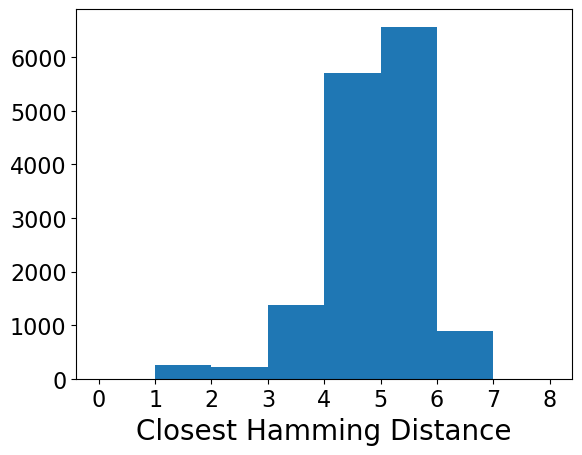

In [56]:
plt.hist(closest_match_list,bins=range(0,9))
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig("./figure_2.png",dpi=300,bbox_inches="tight")
plt.show()

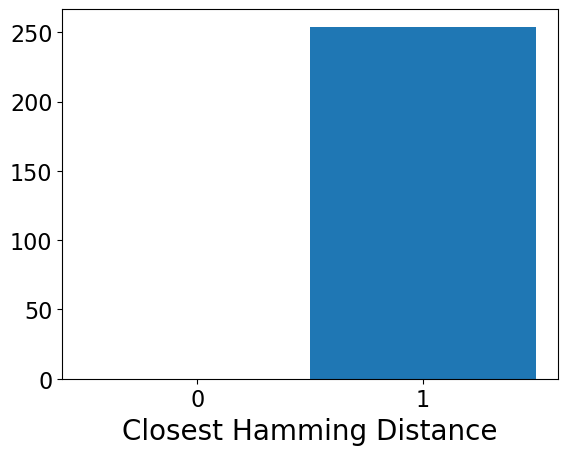

In [57]:
plt.hist(closest_match_list,range=(0,1),bins=2)
plt.xlabel("Closest Hamming Distance",fontsize=20)
plt.xticks([0.25,0.75],[0,1],fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig("./figure_3.png",dpi=300,bbox_inches="tight")
plt.show()

### Depth Distribution

In [58]:
import pickle as pkl
import scipy as sp
    
with open('/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/graph_output/barcode_counts_dict.pkl', 'rb') as infile:
    depth_dict = pkl.load(infile)

In [59]:
depth_arr = np.array(list(depth_dict.values()))

In [60]:
np.sum(depth_arr)

16026457

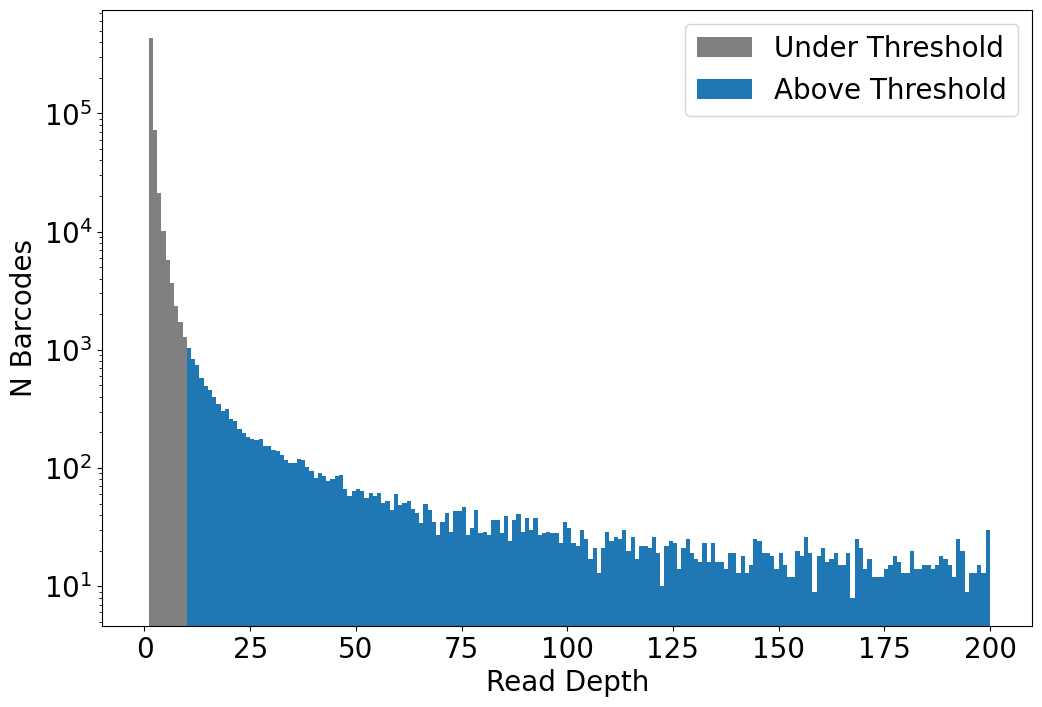

In [61]:
fig = plt.figure(figsize=(12, 8))

threshold=10

under_threshold_arr = depth_arr[depth_arr<threshold]
above_threshold_arr = depth_arr[depth_arr>=threshold]
plt.hist(under_threshold_arr, bins=200, range=(0,200), log=True, color="grey", label="Under Threshold")
plt.hist(above_threshold_arr, bins=200, range=(0,200), log=True, color="tab:blue", label="Above Threshold")
plt.xlabel("Read Depth",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("N Barcodes",fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.savefig("./depth_distribution.png",dpi=300,bbox_inches="tight")
plt.show()

In [62]:
data_df = dd.from_pandas(data,npartitions=100).persist()

In [63]:
data_df

,Unnamed: 0,barcodeid,barcode,consensus,reference,alignmentstart,cigar,subsample
npartitions=100,,,,,,,,
0,int64,int64,object,object,object,int64,object,float64
151,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
14870,...,...,...,...,...,...,...,...
15019,...,...,...,...,...,...,...,...


In [64]:
## Align consensus sequence to reference using cigar string
aligned_cons = data_df.apply(lambda x: align_read(x["consensus"],x["reference"],x["cigar"],startpos=x["alignmentstart"]), axis=1).persist()
## Use GFA reference to determine intervals for each annotation 
ref_intervals = get_ref_intervals("./aDE12.gfa")
## Split sequences based on annotated intervals
split_ref = data_df.apply(lambda x: splitstr(x["reference"],ref_intervals), axis=1).persist()
split_align = aligned_cons.apply(lambda x: splitstr(x,ref_intervals)).persist()

data_df["aligned_cons"] = aligned_cons
data_df["split_ref"] = split_ref
data_df["split_align"] = split_align

## Compute hamming distance from reference, by annotated element
hamm_ref = data_df.apply(lambda x: get_dict_dist(x["split_align"],x["split_ref"]), axis=1, meta=dict).persist()

## Get promoters and UMIs
UMI = data_df["split_align"].apply(lambda x: x["Variant"][274:294], meta=str).persist()
sgRNA = data_df["split_align"].apply(lambda x: str(Seq(x["Variant"][175:195]).reverse_complement()), meta=str).persist()
## Assign closest match to each barcode (for costructing output df later)
closest_hamming_dist = data_df["barcode"].compute().apply(lambda x: closest_match_dict[x])

data_df["hamm_ref"] = hamm_ref
data_df["UMI"] = UMI
data_df["sgRNA"] = sgRNA
data_df["Closest Hamming Distance"] = closest_hamming_dist
data_df = data_df.persist()

del hamm_ref
del closest_hamming_dist
del aligned_cons
del split_align
del split_ref

data_df = data_df.compute()

/home/lag36/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:5690: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))
/home/lag36/miniconda3/envs/crispri/lib/python3.10/site-packages/dask/dataframe/core.py:5690: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, 

### Frequency Distributions

In [65]:
n_barcodes = data_df.groupby("sgRNA").size()[101:]

In [68]:
n_barcodes

sgRNA
ACACGCTAGGAAAAAGCCAG    22
ACACGGCATGTACTAGTGTC     1
ACACGTCCAGCGATGTTATG     1
ACACTGCGCGCCCGCATCTT     2
ACACTGCGCGCCCGCTTCTT    10
                        ..
TTTTTCGAGAATTATGGCAA     1
TTTTTCTTCGGCATCATAAT     1
TTTTTGGAACGAACGATCTT     1
TTTTTTCAAAAGAGCAATAC     1
TTTTTTGAACCGACGATCTT    15
Length: 1634, dtype: int64

(array([  0., 939.,  34.,  21.,  13.,  14.,  20.,  16.,  19.,  33.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

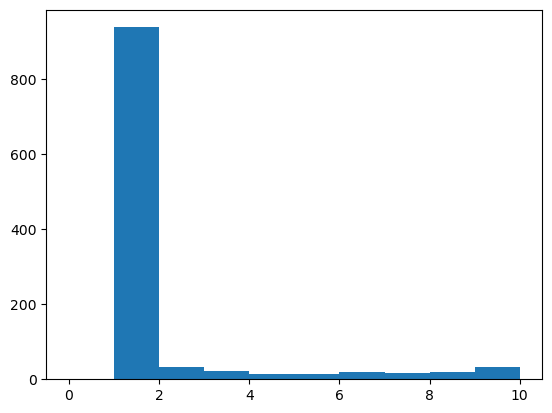

In [67]:
plt.hist(n_barcodes,range=(0,10))

In [71]:
sgRNA_data = pd.read_csv("/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/2021-04-20_Essential_KO_Lib_df_coords_corrected.tsv",sep="\t")
sgRNA_data = sgRNA_data[(sgRNA_data["Category"] != "OnlyChr")&(sgRNA_data["Category"] != "NonEssentialOnlyChr")]

sgRNA_dict = sgRNA_data["sgRNA Sequence"].to_dict()
sgRNA_inv_dict = {val:key for key,val in sgRNA_dict.items()}

valid_mask = data_df["sgRNA"].isin(sgRNA_inv_dict.keys())
valid_data_df = data_df[valid_mask]
index_map = valid_data_df["sgRNA"].apply(lambda x: sgRNA_inv_dict[x])
sgRNA_data_subset = sgRNA_data.loc[index_map.to_list()]

merged_df = valid_data_df.reset_index(drop=True).join(sgRNA_data_subset[["oDEPool7_id","EcoWG1_id","Gene","Strand","Target Sequence","Target Sites",\
                                                             "N Target Sites","N Mismatch","Category","TargetID"]].reset_index(drop=True))
merged_df['barcode depth'] = merged_df['barcode'].apply(lambda x: depth_dict[x])

In [72]:
## Storing dataframe as a csv
merged_df.to_csv("/home/lag36/scratch/lag36/2023-03-10_lDE26_Nanopore/lDE26_final_df.tsv",sep="\t")

In [73]:
merged_df

,Unnamed: 0,barcodeid,barcode,consensus,reference,alignmentstart,cigar,subsample,aligned_cons,split_ref,...,EcoWG1_id,Gene,Strand,Target Sequence,Target Sites,N Target Sites,N Mismatch,Category,TargetID,barcode depth
0,0,0,000000000000000001011010100110,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,986M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,7014.0,nusB,+,GCTGCTCGTCGCCGCGCTCG,"[(435146, 435165, '+')]",1.0,3.0,Target,856,795
1,1,1,000000000000001001110001010001,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,273M1I285M1D427M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,NaN,NaN,NaN,AGTGCAGTTGGAGGTAGCTG,NaN,NaN,NaN,NoTarget,2741,360
2,2,2,000000000000001100101001100100,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,986M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,8358.0,folD,-,GCTCTTATGACCTCCCGGAA,"[(557526, 557545, '-')]",1.0,0.0,Target,1070,427
3,3,3,000000000000010100110010110101,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,613M1I373M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,7258.0,glnS,+,ATTATTTTGATCAGCTCCAC,"[(706397, 706416, '+')]",1.0,1.0,Target,904,632
4,4,4,000000000000101111100011010110,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,375M1I611M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,5407.0,lspA,+,CCTTCAACCTTGCCGATACT,"[(25613, 25632, '+')]",1.0,8.0,Target,646,367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13938,15015,15015,111111110111001011111100110111,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,986M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,784.0,racR,-,AGCGATAGAGCAGGCCATTA,"[(1420196, 1420215, '-')]",1.0,7.0,Target,87,887
13939,15016,15016,111111110111001100010101011010,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,986M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,19266.0,lolB,-,GCTTTTTCTGGCAGCAAACC,"[(1263273, 1263292, '-')]",1.0,4.0,Target,2453,258
13940,15017,15017,111111110111001111000010101001,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,986M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,15554.0,ffs,+,GAAGGAAGCAGCCAAGGCAG,"[(476501, 476520, '+')]",1.0,2.0,Target,1962,1362
13941,15018,15018,111111110111010101100001010010,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,1,331M1D654M,NaN,ATTTGTCCTACTCAGGAGAGCGTTCACCGACAAACAACAGATAAAA...,{'Variant': 'ATTTGTCCTACTCAGGAGAGCGTTCACCGACAA...,...,825.0,secY,-,CTGTACTTGCCAAACTGCTT,"[(3443939, 3443958, '-')]",1.0,4.0,Target,95,4592


In [77]:
merged_df.groupby('sgRNA').size()

sgRNA
AAAACAGGTGCTCCAGGGTA    16
AAAACCGGTGCCTTACCGCT    18
AAACCTTGAGACAGAGTTAT     2
AAAGATGGATCGAGGAAAAT     2
AAATGACATGGGGCAATGGC    25
                        ..
TTTGTTCGGTCAGCAGGGCC    22
TTTTAGGGTCGACTTTATTC     6
TTTTGTTCGATCAGCATTTC    23
TTTTTCCAGCCGTTTGGTCA    49
TTTTTTGAACCGACGATCTT    15
Length: 736, dtype: int64

(array([ 0., 23., 21., 17., 13., 15., 20., 19., 20., 35.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

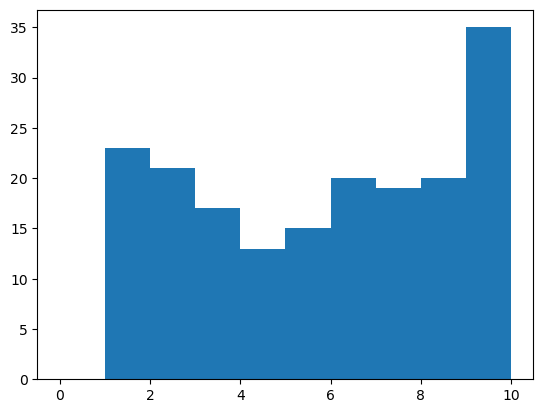

In [79]:
plt.hist(merged_df.groupby('sgRNA').size(), range=(0,10))

In [ ]:
dask_controller.shutdown()